# シンプルなFC層を用いたモデル（時間情報部分的にあり）

### 方針

・内部に問題ごとの依存関係を定義し、その関係をもとに遷移させる。

・条件付き確率（遷移確率）と周辺分布の積の和から次の周辺分布を求める。

・まずは遷移過程が部分的にしか分からない人工データを用意し、モデルを学習する。

### データの生成

・データの用意

In [1]:
import numpy as np

# 問題の依存関係の行列 A 
A = np.array([
    [0, 0, 0, 0, 0, 0],  # 初期状態
    [1, 0, 0, 0, 0, 0],  # 問題1は初期状態のみに依存
    [1, 0, 0, 0, 0, 0],  # 問題2は問題1に依存
    [0, 1, 1, 0, 0, 0],  # 問題3は問題2に依存
    [0, 0, 0, 1, 0, 0],  # 問題4は問題2、問題3に依存
    [0, 0, 0, 0, 1, 0]   # 問題4は問題2、問題3に依存
])


# 遷移確率を計算する関数
def calculate_transition_probabilities(A, X):
    n = len(X)
    raw_probabilities = np.zeros(n)  # 遷移確率の元となる値
    
    # 不正解の問題に対して遷移確率を計算
    for i in range(n):
        if X[i] == 0:  # 不正解の問題のみ計算
            required_problems = A[i, :]  # i番目の問題に必要な依存関係
            
            # # 依存関係がすべて0であるかを確認
            # if np.all(required_problems == 0):
            #     raw_probabilities[i] =  10  # 必要なら、この問題の遷移確率を設定
            #     continue
            
            solved_problems = X * required_problems  # 実際に解けた問題
            
            num_required = np.sum(required_problems)  # 必要な問題の数
            num_solved = np.sum(solved_problems)      # 実際に解けた問題の数
            
            if num_required > 0:
                raw_probabilities[i] = np.exp(num_solved / num_required)
    
    # 総和で割って正規化
    total_sum = np.sum(raw_probabilities)  # expの総和
    if total_sum > 0:  # 総和が0でなければ正規化
        probabilities = raw_probabilities / total_sum
    else:
        probabilities = raw_probabilities  # 総和が0ならそのまま
    
    return probabilities

In [2]:
# 教師データセットを生成する関数
def generate_training_data(A, initial_X, num_correct_problems, num_data_per_step):
    n = len(initial_X)  # 問題数
    dataset = []
    
    # 各ステップでデータを生成
    for i in range(num_correct_problems, num_correct_problems + 1):  # 初期状態から最後まで正解させる
        for j in range(num_data_per_step):  # 各ステップごとにデータ数
            X = initial_X.copy()  # 初期状態からスタート
            
            # i問正解させる
            for k in range(i):
                if k % 2 == 0:
                    input_X = X.copy()    # 遷移前状態を保持

                probabilities = calculate_transition_probabilities(A, X)
                
                if np.sum(probabilities) > 0:  # 正規化された確率がある場合
                    # 確率に基づいて次に正解させる問題を選択
                    next_correct_problem = np.random.choice(n, p=probabilities)
                    X[next_correct_problem] = 1  # 選ばれた問題を正解に遷移させる
                
                if k % 2 != 0:  # 2,4問正解の時のみ正解ラベルを作成
                    # 初期状態と1ステップ後の状態の差分を教師データとして使用
                    target_Y = (X - input_X).clip(min=0)  # 0から1に変わった部分のみを1、他は0
                    print(f"input_X: {input_X}, target_Y: {target_Y}")
                    # 初期状態（入力）と差分（教師データ）のペアを保存
                    dataset.append((input_X.copy(), target_Y.copy()))  # (入力データ, 教師データ)
    return dataset


## モデル

### FCモデル

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [4]:
import torch
import numpy as np


def _bcsoftmax1d(x, budget):
    """Budget Constrained Softmax function for vector.

    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    x = x - torch.max(x, dim=0)[0] # normalization to avoid numerical errors
    exp_x = torch.exp(x)
    # sorting
    _, indices = torch.sort(budget / exp_x, descending=False)
    exp_x = exp_x[indices]
    budget = budget[indices]
    # find K_B
    r = torch.flip(torch.cumsum(torch.flip(exp_x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    z = r / s
    is_in_KB = torch.logical_and(
        (s - budget) > 0, exp_x / z > budget
    )
    # compute outputs
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


def _bcsoftmax1d_stable(x, budget):
    """Budget Constrained Softmax function for vector.
    This function is more numerically stable than `_bcsoftmax1d` by computing some values in log-scale.
    
    Args:
        x (Tensor): input vector. shape: (n_outputs, )
        budget (Tensor): budget (constraint) vector. shape: (n_outputs, )

    Returns:
        y (Tensor): output probability vector. shape: (n_outputs, ). Satisfying the constraints y_i <= budget_i.
    
    """
    # sorting
    _, indices = torch.sort(torch.log(budget) - x, descending=False)
    x = x[indices]
    budget = budget[indices]
    # find K_B
    log_r = torch.flip(torch.logcumsumexp(torch.flip(x, dims=(0, )), dim=0), dims=(0, ))
    s = 1.0 - (torch.cumsum(budget, dim=0) - budget)
    is_in_KB = torch.logical_or(
        budget == 0,
        torch.logical_and(
            s - budget > 0,
            x - log_r + torch.log(s) > torch.log(budget)
        )
    )
    # compute outputs
    exp_x = torch.exp(x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0])
    s = 1 - torch.sum(budget * is_in_KB)
    r = torch.sum(exp_x * (~is_in_KB))
    y = torch.where(~is_in_KB, s * exp_x / r, budget)
    # undo sorting
    _, inv_indices = torch.sort(indices, descending=False)
    return y[inv_indices]


class BCSoftmax1d(torch.autograd.Function):
    """Autograd implementation of Budget Constrained Softmax function for vector.
    """
    generate_vmap_rule = True
    
    @staticmethod
    def forward(x, c):
        y = _bcsoftmax1d_stable(x, c)
        return y

    @staticmethod
    def setup_context(ctx, inputs, output):
        x, c = inputs
        is_in_KB = c == output
        ctx.save_for_backward(x, c, is_in_KB)
    
    @staticmethod
    def backward(ctx, grad_y):
        x, c, is_in_KB = ctx.saved_tensors
        exp_x = torch.exp(
            x - torch.max(torch.where(~is_in_KB, x, -torch.inf), dim=0)[0]
        )
        s = 1 - torch.sum(c * is_in_KB)
        r = torch.sum(exp_x * (~is_in_KB))
        
        # compute Jacobian
        Jx = torch.where(
            torch.outer(~is_in_KB, ~is_in_KB),
            torch.diag(~is_in_KB * exp_x) * r - torch.outer(exp_x, exp_x),
            0,
        )
        Jx *= torch.where(
            s > 0,
            s / (r * r),
            0
        )
        Jc = torch.where(
            torch.outer(~is_in_KB, is_in_KB),
            - exp_x[:, None] / r,
            1.0 * torch.diag(is_in_KB)
        )

        # print("s", s, "r", r)
        # print("勾配", torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc))
        

        # return vector-Jacobian product
        return torch.matmul(grad_y, Jx), torch.matmul(grad_y, Jc)

In [5]:
bcsoftmax1d = BCSoftmax1d.apply
bcsoftmax2d = torch.vmap(BCSoftmax1d.apply)

In [6]:
class Model(nn.Module):
    def __init__(self, num_questions):
        super(Model, self).__init__()
        self.fc = nn.Linear(num_questions, num_questions, bias=False)  # 全結合層

    def forward(self, x, c):
        x = self.fc(x)  # 全結合層の適用
        x = bcsoftmax2d(x, c)
        return x

In [7]:
# データセット生成
num_questions = 5  # 問題数
num_data_per_step = 10000     # 各ステップごとに生成するデータ数

# 生徒の回答状況 X (1が正解、0が不正解)
# 初期状態は全て不正解
X_init = np.array([1, 0, 0, 0, 0, 0])

training_data = generate_training_data(A, X_init, num_questions, num_data_per_step)

# PyTorch テンソルに変換
train_X = torch.tensor([input_data for input_data, _ in training_data], dtype=torch.float32)
train_Y = torch.tensor([target_data for _, target_data in training_data], dtype=torch.float32)

# モデル、損失関数、最適化関数の設定
model = Model(num_questions+1)  # 5問+初期状態の問題を扱うモデル
criterion = nn.CrossEntropyLoss()  # クロスエントロピー損失
optimizer = optim.Adam(model.parameters(), lr=0.01)

input_X: [1 0 0 0 0 0], target_Y: [0 1 0 1 0 0]
input_X: [1 1 0 1 0 0], target_Y: [0 0 1 0 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 1 1 0 0 0]
input_X: [1 1 1 0 0 0], target_Y: [0 0 0 1 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 1 0 1 0]
input_X: [1 0 1 0 1 0], target_Y: [0 1 0 0 0 1]
input_X: [1 0 0 0 0 0], target_Y: [0 1 1 0 0 0]
input_X: [1 1 1 0 0 0], target_Y: [0 0 0 1 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 1 0 0 1]
input_X: [1 0 1 0 0 1], target_Y: [0 1 0 1 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 0 1 0 1]
input_X: [1 0 0 1 0 1], target_Y: [0 1 1 0 0 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 1 0 0 1]
input_X: [1 0 1 0 0 1], target_Y: [0 0 0 1 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 1 0 0 1 0]
input_X: [1 1 0 0 1 0], target_Y: [0 0 1 0 0 1]
input_X: [1 0 0 0 0 0], target_Y: [0 1 1 0 0 0]
input_X: [1 1 1 0 0 0], target_Y: [0 0 0 1 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 0 1 1 0 0]
input_X: [1 0 1 1 0 0], target_Y: [0 1 0 0 1 0]
input_X: [1 0 0 0 0 0], target_Y: [0 1 0

/var/folders/zg/773ptkr55z99zw26dvy19_v00000gn/T/ipykernel_55761/2631755299.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  train_X = torch.tensor([input_data for input_data, _ in training_data], dtype=torch.float32)


In [8]:
import itertools
from collections import defaultdict

# Generate states where the first digit is always 1
states = [(1,) + state for state in itertools.product([0, 1], repeat=num_questions)]
print(f"Number of States: {len(states)}\n")

# Initialize the state counts
state_counts = defaultdict(int)

# Assuming 'dataset' is your list of student results
for result, result2 in training_data:
    # print(result2)
    state_tuple = tuple(map(int, result + result2))  # Convert np.int64 to int
    state_counts[state_tuple] += 1  # Count only if the first digit is 1

print(state_counts)

# Display the counts for each state
for state in states:
    count = state_counts[state]
    formatted_state = list(state)  # Convert tuple to list for the desired format
    print(f"State {formatted_state}: {count} students")

print(state_counts)

Number of States: 32

defaultdict(<class 'int'>, {(1, 1, 0, 1, 0, 0): 1208, (1, 1, 1, 1, 1, 0): 3400, (1, 1, 1, 0, 0, 0): 2702, (1, 0, 1, 0, 1, 0): 840, (1, 1, 1, 0, 1, 1): 1954, (1, 0, 1, 0, 0, 1): 936, (1, 1, 1, 1, 0, 1): 2332, (1, 0, 0, 1, 0, 1): 282, (1, 0, 1, 1, 1, 1): 1133, (1, 1, 0, 0, 1, 0): 844, (1, 0, 1, 1, 0, 0): 1168, (1, 1, 0, 0, 0, 1): 953, (1, 1, 0, 1, 1, 1): 1181, (1, 0, 0, 1, 1, 0): 519, (1, 0, 0, 0, 1, 1): 548})
State [1, 0, 0, 0, 0, 0]: 0 students
State [1, 0, 0, 0, 0, 1]: 0 students
State [1, 0, 0, 0, 1, 0]: 0 students
State [1, 0, 0, 0, 1, 1]: 548 students
State [1, 0, 0, 1, 0, 0]: 0 students
State [1, 0, 0, 1, 0, 1]: 282 students
State [1, 0, 0, 1, 1, 0]: 519 students
State [1, 0, 0, 1, 1, 1]: 0 students
State [1, 0, 1, 0, 0, 0]: 0 students
State [1, 0, 1, 0, 0, 1]: 936 students
State [1, 0, 1, 0, 1, 0]: 840 students
State [1, 0, 1, 0, 1, 1]: 0 students
State [1, 0, 1, 1, 0, 0]: 1168 students
State [1, 0, 1, 1, 0, 1]: 0 students
State [1, 0, 1, 1, 1, 0]: 0 student

## 学習

In [9]:
# 学習ループ
num_epochs = 4000  # エポック数
alpha = 0.001  # L1正則化の重み  

for epoch in range(num_epochs):
    model.train()  # モデルを訓練モードに
    optimizer.zero_grad()  # 勾配の初期化
    
    c = torch.cat([torch.zeros((train_X.shape[0], 1), dtype=torch.float32), torch.ones((train_X.shape[0], num_questions), dtype=torch.float32)], dim=1)

    # モデルの予測
    y0 = model(train_X, c) # 1ステップ目の予測
    c = c - y0
    outputs = model(y0 + train_X, c) # 2ステップ目の予測
    
    # L1正則化項の計算
    l1_reg = torch.tensor(0.0, requires_grad=True)
    for param in model.parameters():
        l1_reg = l1_reg + torch.sum(torch.abs(param))

    # 損失の計算
    loss0 = criterion(outputs, train_Y)

    loss = loss0 + alpha * l1_reg  # L1正則化項を追加した損失
    
    # バックプロパゲーションとパラメータの更新
    loss.backward()
    optimizer.step()
    
    # 100エポックごとに損失を表示
    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 学習結果の確認
print("Training complete!")

Epoch [100/4000], Loss: 3.4417
Epoch [200/4000], Loss: 3.4152
Epoch [300/4000], Loss: 3.4036
Epoch [400/4000], Loss: 3.3996
Epoch [500/4000], Loss: 3.3973
Epoch [600/4000], Loss: 3.3954
Epoch [700/4000], Loss: 3.3943
Epoch [800/4000], Loss: 3.3936
Epoch [900/4000], Loss: 3.3931
Epoch [1000/4000], Loss: 3.3928
Epoch [1100/4000], Loss: 3.3923
Epoch [1200/4000], Loss: 3.3917
Epoch [1300/4000], Loss: 3.3910
Epoch [1400/4000], Loss: 3.3903
Epoch [1500/4000], Loss: 3.3898
Epoch [1600/4000], Loss: 3.3895
Epoch [1700/4000], Loss: 3.3893
Epoch [1800/4000], Loss: 3.3892
Epoch [1900/4000], Loss: 3.3890
Epoch [2000/4000], Loss: 3.3889
Epoch [2100/4000], Loss: 3.3888
Epoch [2200/4000], Loss: 3.3887
Epoch [2300/4000], Loss: 3.3887
Epoch [2400/4000], Loss: 3.3887
Epoch [2500/4000], Loss: 3.3887
Epoch [2600/4000], Loss: 3.3887
Epoch [2700/4000], Loss: 3.3886
Epoch [2800/4000], Loss: 3.3886
Epoch [2900/4000], Loss: 3.3886
Epoch [3000/4000], Loss: 3.3886
Epoch [3100/4000], Loss: 3.3886
Epoch [3200/4000]

## テスト

In [10]:
test = np.array([[1, 0, 0, 0, 0, 0]], dtype=np.float32)

# numpy配列をtorch.Tensorに変換
test_tensor = torch.tensor(test, dtype=torch.float32)

model.eval()  # モデルを評価モードに

cy = torch.cat([torch.zeros((test_tensor.shape[0], 1), dtype=torch.float32), torch.ones((test_tensor.shape[0], num_questions), dtype=torch.float32)], dim=1)

# モデルに入力を渡して出力を得る
output = model(test_tensor, cy)
print("Output:", output)

Output: tensor([[0.0000, 0.5440, 0.0920, 0.0035, 0.0048, 0.3556]],
       grad_fn=<VmappedBCSoftmax1dBackward>)


In [11]:
torch.set_printoptions(precision=4, sci_mode=False)
# モデルの各パラメータを表示
for param in model.parameters():
    print(param)
    softmax_param = F.softmax(param, dim=1)  # dim=1 は行ごとにソフトマックスを適用する
    print("結果", softmax_param)
    print("いや、こういうわけではない")

print("正解の依存関係\n", A)

Parameter containing:
tensor([[     0.0001,     -0.0018,     -0.0012,     -0.0016,     -0.0010,
              0.0011],
        [     1.7772,     -3.3289,     -1.7007,      2.4765,      0.0022,
              3.0354],
        [    -0.0000,      2.0493,     -1.9258,     -1.0733,     -0.0004,
              0.0011],
        [    -3.2614,      0.0014,      3.3518,     -0.5046,      0.0020,
              2.4913],
        [    -2.9543,      0.0013,      1.5972,      3.7498,      0.0004,
             -0.0080],
        [     1.3521,     -4.1662,     -0.0027,     -0.0015,      3.8026,
             -1.9798]], requires_grad=True)
結果 tensor([[    0.1668,     0.1665,     0.1666,     0.1665,     0.1666,     0.1670],
        [    0.1484,     0.0009,     0.0046,     0.2987,     0.0252,     0.5223],
        [    0.0889,     0.6899,     0.0130,     0.0304,     0.0888,     0.0890],
        [    0.0009,     0.0231,     0.6598,     0.0140,     0.0232,     0.2791],
        [    0.0010,     0.0198,     0.0978,

・図示

ValueError: vmap: Expected all tensors to have the same size in the mapped dimension, got sizes [1, 20000] for the mapped dimension

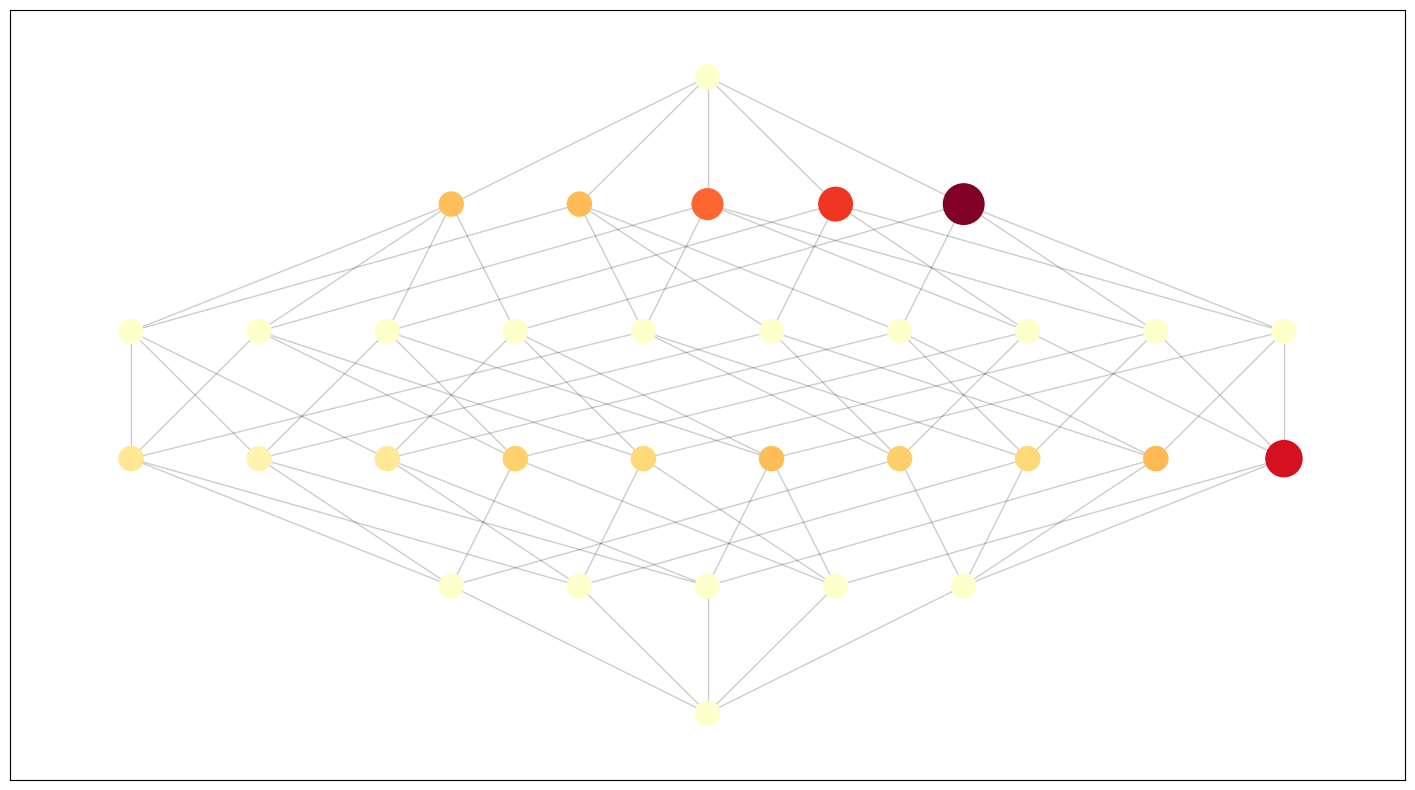

In [12]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Create the graph
G = nx.Graph()

# Add nodes with the 'count' attribute
for state in states:
    G.add_node(state, count=state_counts[state])

# Add edges between states
for state in states:
    for i in range(num_questions+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                G.add_edge(state, next_state)

# Custom layout function with uniform horizontal placement and centered nodes
def custom_layout(G, num_questions):
    pos = {}
    # Group nodes by their level (number of 1's in the state)
    levels = {}
    for state in G.nodes():
        level = sum(state)  # Level is the number of 1's in the state
        if level not in levels:
            levels[level] = []
        levels[level].append(state)
    
    # Determine the x and y positions for each node
    for level, states_at_level in levels.items():
        num_nodes_at_level = len(states_at_level)
        for i, state in enumerate(sorted(states_at_level)):
            # x position is evenly spaced horizontally for each level
            x = i - (num_nodes_at_level - 1) / 2  # Center horizontally
            y = level  # y position is the level itself (number of 1's)
            pos[state] = (x, y)
    
    return pos


# Apply the custom layout
pos = custom_layout(G, num_questions)

# Normalize x positions
x_values = [pos[node][0] for node in pos]
min_x, max_x = min(x_values), max(x_values)
for node in pos:
    x, y = pos[node]
    x_norm = (x - min_x) / (max_x - min_x)
    pos[node] = (x_norm, y)

# Plot settings
plt.figure(figsize=(18, 10))  # Adjust the figure size as needed

# Draw edges
nx.draw_networkx_edges(G, pos, alpha=0.2)

# Adjust node sizes according to the number of students
node_sizes = []
for node in G.nodes():
    count = G.nodes[node]['count']
    size = max(300, min(6000, count/4))  # Increase the minimum size to 600
    node_sizes.append(size)


# Node colors based on the number of students
node_colors = [G.nodes[node]['count'] for node in G.nodes()]
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.YlOrRd
)

# Create labels including the student counts
labels = {
    node: f"{''.join(map(str, node))}\n{G.nodes[node]['count']} students"
    for node in G.nodes()
}

# Transition probabilities: add labels to edges, including predicted values
edge_labels = {}
for state in states:
    probabilities = calculate_transition_probabilities(A, np.array(state))
    predicted_values = output = model(torch.tensor([state], dtype=torch.float32), c)  # 予測値を計算
    print(f"State: {state}, Probabilities: {probabilities}, Predicted Values: {predicted_values}")

    for i in range(num_questions+1):
        next_state = list(state)
        if next_state[i] == 0:
            next_state[i] = 1
            next_state = tuple(next_state)
            if next_state in states:
                # 遷移確率と予測値をラベルに追加
                transition_probability = f"{probabilities[i]:.2f}"
                predicted_value = f"({predicted_values[0][i]:.2f})"  # 予測値を表示
                edge_labels[(state, next_state)] = f"{transition_probability}\n{predicted_value}"


# Draw node labels
nx.draw_networkx_labels(G, pos, labels, font_size=12)
# Draw edge labels with transition probabilities
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8, label_pos=0.6)

# カラーバーの追加
plt.colorbar(nodes, label='Number of Students')

# グラフ描画の最後にコメントを追加
plt.text(
    0.5, -0.05,  # テキストの位置 (x, y)。x=0.5 は中央、y=1.05 はグラフの上
    "edges: transition probability\n (): predicted transition probability",  # 表示したいテキスト
    horizontalalignment='center',  # テキストの水平方向の配置（中央揃え）
    verticalalignment='center',    # テキストの垂直方向の配置（中央揃え）
    transform=plt.gca().transAxes,  # Axes の座標系で位置を指定 (0-1の範囲)
    fontsize=12,                    # フォントサイズ
    color="black"                   # テキストの色
)

plt.title('Vertical Network Graph of Test Results with Transition Probabilities')
plt.axis('off')
plt.tight_layout()

# Display the graph
plt.show()

# Print the state counts
print("State counts:")
for state, count in sorted(state_counts.items(), key=lambda x: sum(x[0])):
    print(f"State {''.join(map(str, state))}: {count} students")